# Project Initialization

## Keywords


*   Time Series Forecasting
*   Seasonal Decomposition
*   Stationarity Testing
*   ACF + PACF
*   ARIMA
*   SARIMAX


## Background Research 


The goal for this project is to perform Time Series Forecasting on Air Pollution Dataset. We are given a training dataset to build your time series model, and to make prediction using the test dataset.

## Objective

> To forecast the Air Quality of Carbon Monoxide CO, Hydrocarbon(s) HC, Nitrous Dioxide NO2 and Ozone O3 for the next 63 Days(test size) using Univariate and Multivariate Statistical Model.

### Define "Value" feature in Raw Datast 


## Dataset Background

After some digging, I found that the original source of the dataset is from  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality). 

What's interesting is that they denoted:

> "Missing values are tagged with -200 value" 

The original dataset collected readings on a hourly basis. However, the data from dataset given is on a daily basis. After manually calculating certain rows,we can confirm that the daily readings are derived from averaging the 24hours of that particular day.

For now, we will keep this fact in mind and explore more on the implicaitons of missing values in the EDA process



## Load Dependencies

In [5]:
%pip install -r requirements.txt


     ---------------------------------------- 4.9/4.9 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 48.3/48.3 KB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 6.6/6.6 MB 15.0 MB/s eta 0:00:00
     --------------------------------------- 14.1/14.1 MB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 11.8/11.8 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 37.8/37.8 MB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 208.1/208.1 KB 12.4 MB/s eta 0:00:00
     -----------------------------

ERROR: Could not find a version that satisfies the requirement plotly-express==0.8.2 (from versions: 0.1a1, 0.1a2, 0.1a3, 0.1a4, 0.1a5, 0.1a6, 0.1a7, 0.1a8, 0.1, 0.1.1, 0.1.2, 0.1.3, 0.1.4, 0.1.5, 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.3.0, 0.3.1, 0.4.0, 0.4.1)
ERROR: No matching distribution found for plotly-express==0.8.2


In [2]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
# from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models
from joblib import Parallel, delayed # Parallelise our grid search
from IPython.display import display, HTML, Markdown
# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Load Train Dataset
Date formatting of the data does not follow the standard Pandas convention.
Therefore specift date formatting to convert date feature to Datetime

Time range for Train Dataset spans over 13 months from 03-2016 to 02-2017

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/Datasets/train.csv')
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format="%d/%m/%Y") # Convert Date feature [Object --> Datetime]
display(df_raw)

NameError: name 'pd' is not defined

In [ ]:
print(f'Start Date:{df_raw["Date"].min()}\nEnd Date: {df_raw["Date"].max()}')

Start Date:2016-03-15 00:00:00
End Date: 2017-02-05 00:00:00


## Datetime Index

Since we are given a panel data, a time series with more than one relative variable in the same period.

We will be creating a datetime index 

In [ ]:
df_raw.set_index('Date', inplace=True)
display(df_raw)

,T,RH,Gas,Value,Unnamed: 5,Unnamed: 6
Date,,,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000,NaN,NaN
2016-03-16,9.833333,64.069791,CO,995.250000,NaN,NaN
2016-03-17,11.292708,51.107292,CO,1025.250000,NaN,NaN
2016-03-18,12.866319,51.530903,CO,1064.444444,NaN,NaN
2016-03-19,16.016667,48.843750,CO,1088.741667,NaN,NaN
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,O3,553.180556,NaN,NaN
2017-02-02,-55.515972,-24.010417,O3,343.500000,NaN,NaN
2017-02-03,-14.272917,28.563542,O3,334.458333,NaN,NaN


# Exploratory Data Analysis

In our EDA for time series anaylsis on Air pollution dataset. We want to acomplish the following: 


*   Visualize Time series
*   Check Stationary of Data
*   Decompose the time series into it's components
  *  Seasonal Component ($S_t$)
  *  Trend-Cycle component ($T_t$)
  *  Remainder components ($R_t$)
* Strength of Trend and Seasonality of Gas values


## Initial Time series Visualization



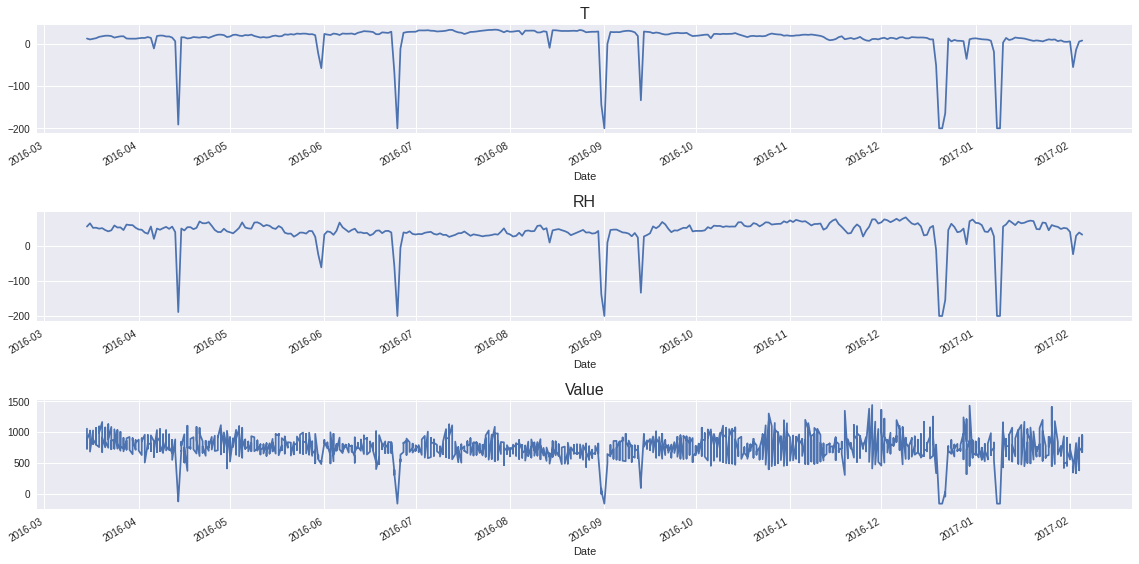

In [ ]:
features = ["T",	"RH",	"Value"]

# Seaborn plot styling

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.autolayout'] = True


# Preliminary Line Plots
fig = plt.figure(tight_layout=True)
for i, column in enumerate(features):
    ax = fig.add_subplot(len(features), 1, i + 1)
    df_raw[column].plot(ax=ax)
    ax.set_title(column, fontsize=16)
plt.show()

Observations: 


*   There is a consistent reoccurence in extreme negative values across T , RH and Value series. I.e When any features T, RH or Values spikes towards a negative values at a particular point in time all feautues will spike down at the datetime index
*   Value Series looks too clustered, with high variance in quantity.


Actions

* Perform E-noise Drifting for negative Values 
* check on Value and it's relationship with other variables

## Pivoting Table
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row turning every gas into its individual column. 

In [ ]:
df_raw_pivot = pd.pivot(df_raw, values="Value", columns="Gas")
df_raw_pivot[["T", "RH"]] = df_raw[["T", "RH"]].groupby(df_raw.index).mean()

df_raw_pivot

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,474.291667,347.480556,508.180556,343.500000,-55.515972,-24.010417
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542


## What's the frequency of time series data

In [ ]:
df_raw_pivot.index

DatetimeIndex(['2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18',
               '2016-03-19', '2016-03-20', '2016-03-21', '2016-03-22',
               '2016-03-23', '2016-03-24',
               ...
               '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03',
               '2017-02-04', '2017-02-05'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

From the looks of sameple index, it seems to be daily. We still will need to verify this


In [ ]:
len(df_raw_pivot) - len(df_raw_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency

In [ ]:
df_raw_pivot = df_raw_pivot.asfreq("D") # explicitly state a daily frequency

## Missing Values

After some digging, I found that the original source of the dataset is from  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality). 

What's interesting is that they denoted:

> "Missing values are tagged with -200 value" 

Let's take a deeper analysis to check the implications when -200 on the Values of Gases

In [ ]:
display(df_raw_pivot[df_raw_pivot['T'] == -200])

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-06-25,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-09-01,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-20,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-21,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-08,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-09,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0


Observations:
When Temperature `T` or `RH` have Values of -200, all the other gases will have values of -160

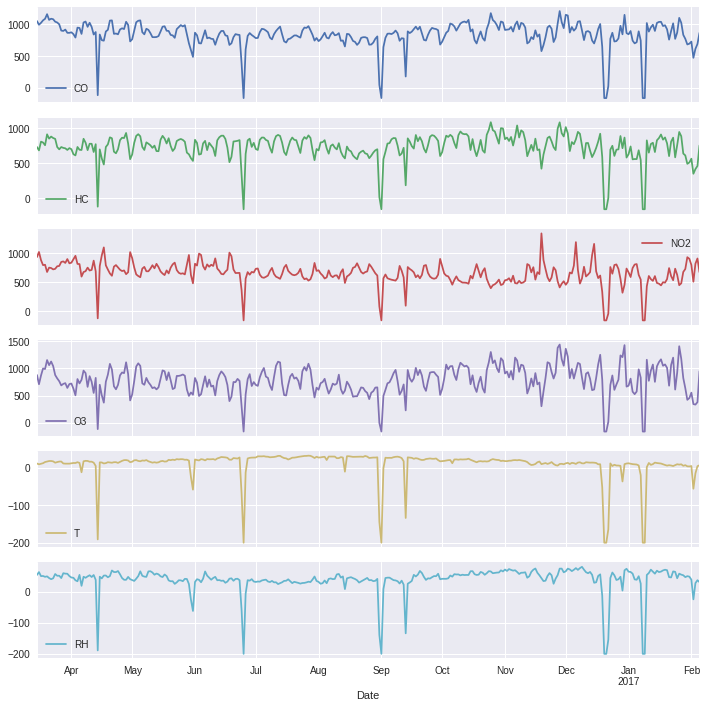

In [ ]:
df_raw_pivot.plot(subplots=True, figsize=(10, 10))
plt.show()

**Observations**



*   There's interesting trend that when either one of the gasses are tagged with -160 value, the rest of the gasses will be -160 as well
*   The extreme values 

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

**Action**

*    impute the missing value using the front-fill(replace missing value with value before) method instead of dropping it.




In [ ]:
Gases = ['CO','HC','NO2','O3']


display(df_raw_pivot[(df_raw_pivot[Gases]== -160).any(axis = 1)]) # Show Row with -160
df_pivot_impute = df_raw_pivot[['CO','HC','NO2','O3','T','RH']].replace({-160: np.NaN,-200: np.NaN}) # Replace Gases Values -160 and Temperature/RH values -200 with Null

df_pivot_impute = df_pivot_impute.sort_index().fillna(method='ffill') # Sort Index and Front-Fill
print("\nNumber of Missing Rows : \n{}".format(df_pivot_impute.isnull().sum()))



Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-06-25,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-09-01,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-20,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-21,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-08,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-09,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0



Number of Missing Rows : 
Gas
CO     0
HC     0
NO2    0
O3     0
T      0
RH     0
dtype: int64


## E-Nose Drifting

Even after imputing the missing values -200 and -160 as NaN.

The minumum values for Temperature is still -191 degrees, which is ilogical for climate in Spain ( which the dataset was taken from )

Furthermore Relative Humidity percentage metric, thus even more ilogical for percentage to be negative



---
After digging around the orginal dataset FROM UCI repository, and comparing it with the given dataset, I found out that when the school merged the hourly readings from the original dataset, they merged days that certain contains both missing and actual readings per hour

As a result if just 1hour out of the 24 hours in a day had actual readings the averaged value will be slightly lower than -200 OR < -160 for gases

In [ ]:
df_pivot_impute.min()

Gas
CO    -114.133333
HC    -122.766667
NO2   -124.466667
O3    -114.958333
T     -191.164583
RH    -188.839583
dtype: float64

## Imputing drifted missing values

We will use a threshold value of `T` < 0 to extract all partically affected missing value ( as explained above )

In [ ]:
# Create Boolean Column to Indicate Drifting when Temperature is less than 0 (Abnormal)
df_pivot_impute['Drift'] = df_pivot_impute['T'] <0
df_pivot_impute

Gas,CO,HC,NO2,O3,T,RH,Drift
Date,,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334,False
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791,False
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292,False
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903,False
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750,False
...,...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930,False
2017-02-02,474.291667,347.480556,508.180556,343.500000,-55.515972,-24.010417,True
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542,True


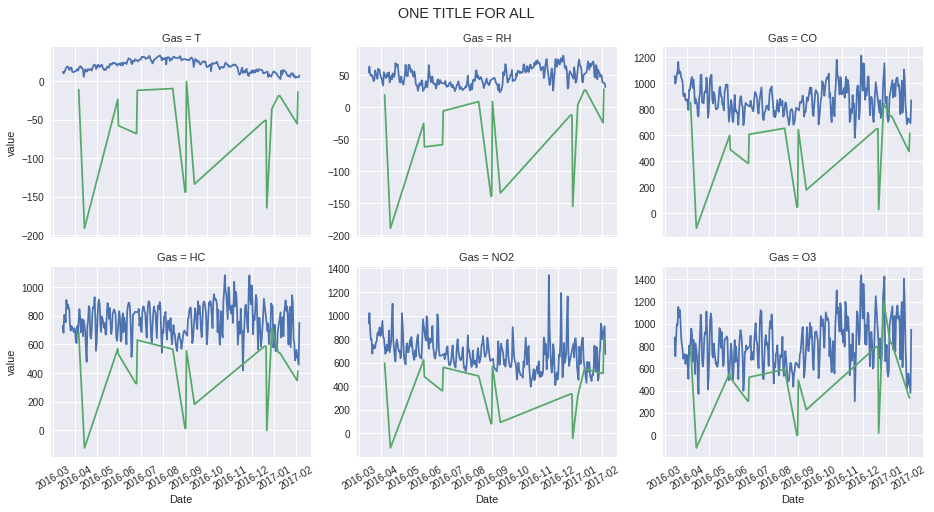

In [ ]:
g = sns.FacetGrid(
        pd.melt(
            df_pivot_impute, 
            id_vars='Drift', 
            value_vars=['T', 'RH', 'CO','HC','NO2','O3'], 
            ignore_index=False).reset_index(), 
        col="Gas", 
        hue = 'Drift',
        col_wrap= 3,
        sharey=False,
        height=3.5,
        aspect=1.25
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in g
g.fig.suptitle('ONE TITLE FOR ALL')

plt.show()

Observations: 
EH RMB ADD THIS AH WALAO

**Action**

Front fill all values for drifted data

In [ ]:
df_pivot_impute.loc[df_pivot_impute['Drift']] = np.nan
df_pivot_impute = df_pivot_impute.fillna(method = 'ffill')
df_pivot_impute.drop(columns= 'Drift', inplace = True)
df_pivot_impute

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-03,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930


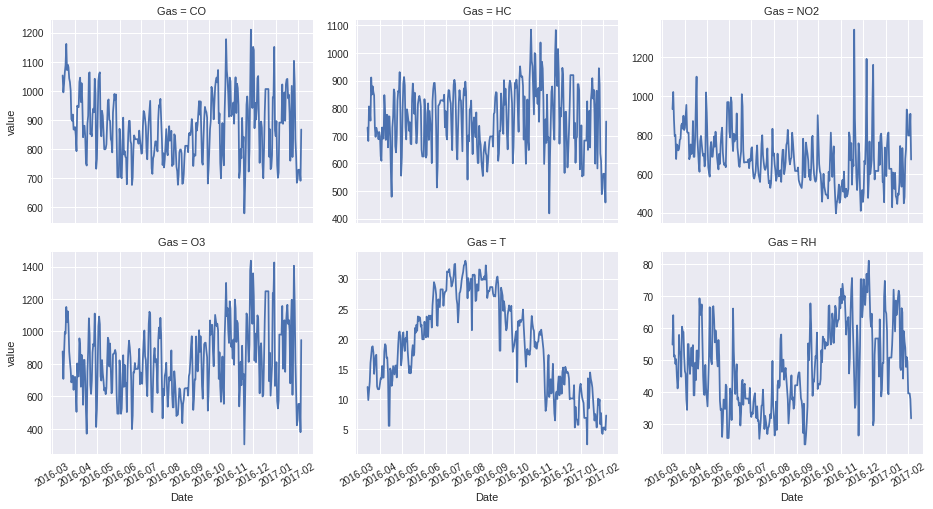

In [ ]:
g = sns.FacetGrid(
        pd.melt(
            df_pivot_impute, 
            ignore_index=False).reset_index(), 
        col="Gas",
        col_wrap= 3,
        sharey=False,
        height=3.5,
        aspect=1.25
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
plt.show()

# Stationary test

Knowing if our data is stationary is neccessary as having Stationary data one of the statistical assumptions that may be made by our models (ARIMA models)

Stationary data represents  **mean, variance and covariance does not vary with time.**

There are two statistical test we can perform to check for stationary data


*   Augmented Dickey-Fuller Test ( ADF )
*   Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

We will choose to apply/run both the tests and makes sure that the series is truly stationary



## ADF test for stationary

To verify stationarity, we will be utilising Augmented Dickey Test at Significant Value, $p=0.05$ with,
$$
H_0 : \text{Time-Series is Non-Stationary} \\
H_1 : \text{Time-Series is Stationary} 
$$

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [ ]:
significance_level = 0.05
for feature in df_pivot_impute.columns:
    print(f'\n{feature}')
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: There is a unit root (non-stationary time series)\nH1: There is no unit root (stationary time series)")
    test_statistic, pvalue, usedlag, *_ = adfuller(df_pivot_impute[feature])
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    display(test_statistic, pvalue, usedlag)



CO
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 1
Reject H0. There is evidence that the time series is stationary.


-8.313006601537845

3.744835659431997e-13

1


HC
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.004
Used Lag: 14
Reject H0. There is evidence that the time series is stationary.


-3.699205090508729

0.004124349155452802

14


NO2
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.001
Used Lag: 6
Reject H0. There is evidence that the time series is stationary.


-3.9908765493765603

0.0014590450326791835

6


O3
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.015
Used Lag: 12
Reject H0. There is evidence that the time series is stationary.


-3.2941324704216797

0.01514279918008528

12


T
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.784
Used Lag: 6
Fail to reject H0. There is insufficient evidence that the time series is stationary.


-0.9120895363373916

0.7839650927246509

6


RH
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.001
Used Lag: 2
Reject H0. There is evidence that the time series is stationary.


-4.2700126459582

0.000500432899979502

2

ADF Observations:

*   All Gases `CO`,`HC`, `NO2` and `O3` time series are stationary at $p=0.05$ 
*   Only `T` temperature does not appear to be stationary 



## KPSS test for stationary

In [ ]:
def KPPS_test(df, significance_level = 0.05, columns = ['CO', 'HC', 'NO2', 'O3', 'T', 'RH']):
  for feature in columns:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      print(f'\n{feature}')
      print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary\nH1: There is a unit root (non-stationary)")
      test_statistic, pvalue, usedlag, *_ = kpss(df[feature], regression="c", nlags="auto")
      print(f"P-value: {pvalue:.3f}")
      print(f"Used Lag: {usedlag}")
      if pvalue < significance_level:
          print("Reject H0. There is evidence that the time series is not stationary.")
      else:
          print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
      display(test_statistic, pvalue, usedlag)

In [ ]:
KPPS_test(df_pivot_impute)


CO
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 8
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.30709743147091745

0.1

8


HC
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 7
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.16100959835235773

0.1

7


NO2
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


1.420563948683637

0.01

8


O3
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


0.8536875424850573

0.01

8


T
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 11
Reject H0. There is evidence that the time series is not stationary.


1.078712824136766

0.01

11


RH
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


1.0137600878710762

0.01

10

KPSS Observations:

*   Only Gases `CO` and `HC` time series are **stationary** at $p=0.05$ 
*   Gases `NO2` and `O3` time series is **not stationary** at $p=0.05$ 
*   Both `T` and `RH` time series is **not stationary** at $p=0.05$ 

## Final Conclusiton for stationary test


1.   Time series for Gases `CO` and `HC`: Both tests conclude that the given series is stationary – These two series is stationary


> No differencing needed


2.  Time series for Gases `NO2` and `O3`: ADF concludes stationary and KPSS concludes non-stationary – These two series is difference stationary.

> Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

3. Time series for `T`: Both tests conclude that the given series is non-stationary – The series is non-stationary

4. Time series for `RH`: ADF concludes stationary and KPSS concludes non-stationary – The series is difference stationary.

[Reference: Statistical tests to check stationarity in Time Series](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=In%20python%2C%20the%20statsmodel%20package,the%20opposite%20to%20each%20other.)







## Differencing 
We will perform differencing on `NO2` and `O3` by compute the differences between consecutive observations using Pandas *diff* function 

In [ ]:
ts_diff = df_pivot_impute.copy()

In [ ]:
def differencing(df,features =[],periods = 1):
  for period in range(2,periods+1):
    print(period)
    for i in features:
      df["diff_"+str(period)+i] = df[i].diff(periods = period)
      df["diff_"+str(period)+i].dropna(inplace=True)
  return df

In [ ]:
ts_diff["diff_1_NO2"] = ts_diff["NO2"].diff(periods=1)
ts_diff["diff_2_NO2"] = ts_diff["NO2"].diff(periods=2)
ts_diff["diff_3_NO2"] = ts_diff["NO2"].diff(periods=3)

ts_diff.head(6)

Gas,CO,HC,NO2,O3,T,RH,diff_1,diff_2,diff_3,diff_1_NO2,diff_2_NO2,diff_3_NO2
Date,,,,,,,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791,87.950000,NaN,NaN,87.950000,NaN,NaN
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292,-140.375000,-52.425000,NaN,-140.375000,-52.425000,NaN
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903,-86.847222,-227.222222,-139.272222,-86.847222,-227.222222,-139.272222
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750,6.355556,-80.491667,-220.866667,6.355556,-80.491667,-220.866667
2016-03-20,1161.608333,911.075000,676.450000,1151.233333,17.370833,50.320833,-124.433333,-118.077778,-204.925000,-124.433333,-118.077778,-204.925000


In [ ]:
diff_no2 = differencing(df_pivot_impute,features = ['NO2'],periods = 2)
display(diff_no2)
display(df_pivot_impute)
# KPPS_test(ts_diff,columns=['NO2',"diff_1_NO2","diff_2_NO2","diff_3_NO2"])

2


Gas,CO,HC,NO2,O3,T,RH,diff_0NO2,diff_1NO2,diff_2NO2
Date,,,,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334,0.0,NaN,NaN
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791,0.0,87.950000,NaN
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292,0.0,-140.375000,-52.425000
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903,0.0,-86.847222,-227.222222
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750,0.0,6.355556,-80.491667
...,...,...,...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930,0.0,-106.269444,-133.755556
2017-02-02,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930,0.0,0.000000,-106.269444
2017-02-03,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930,0.0,0.000000,0.000000


Gas,CO,HC,NO2,O3,T,RH,diff_0NO2,diff_1NO2,diff_2NO2
Date,,,,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334,0.0,NaN,NaN
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791,0.0,87.950000,NaN
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292,0.0,-140.375000,-52.425000
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903,0.0,-86.847222,-227.222222
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750,0.0,6.355556,-80.491667
...,...,...,...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930,0.0,-106.269444,-133.755556
2017-02-02,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930,0.0,0.000000,-106.269444
2017-02-03,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930,0.0,0.000000,0.000000


# Seasonal Decomposition



---

Seasonal Decomposition
Column: CO
Seasonal 7


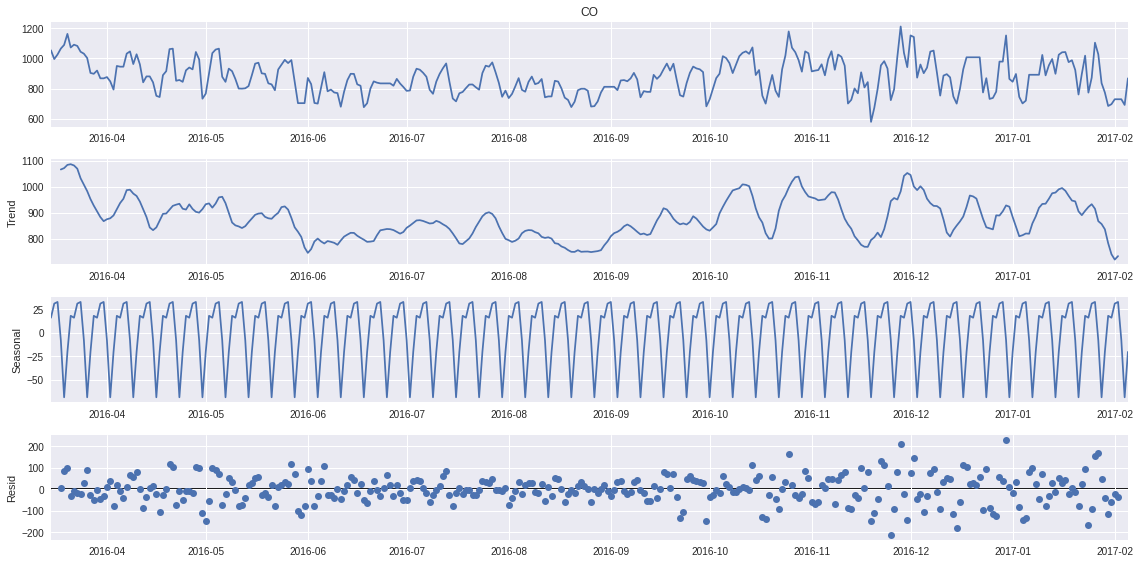

---

Seasonal Decomposition
Column: HC
Seasonal 7


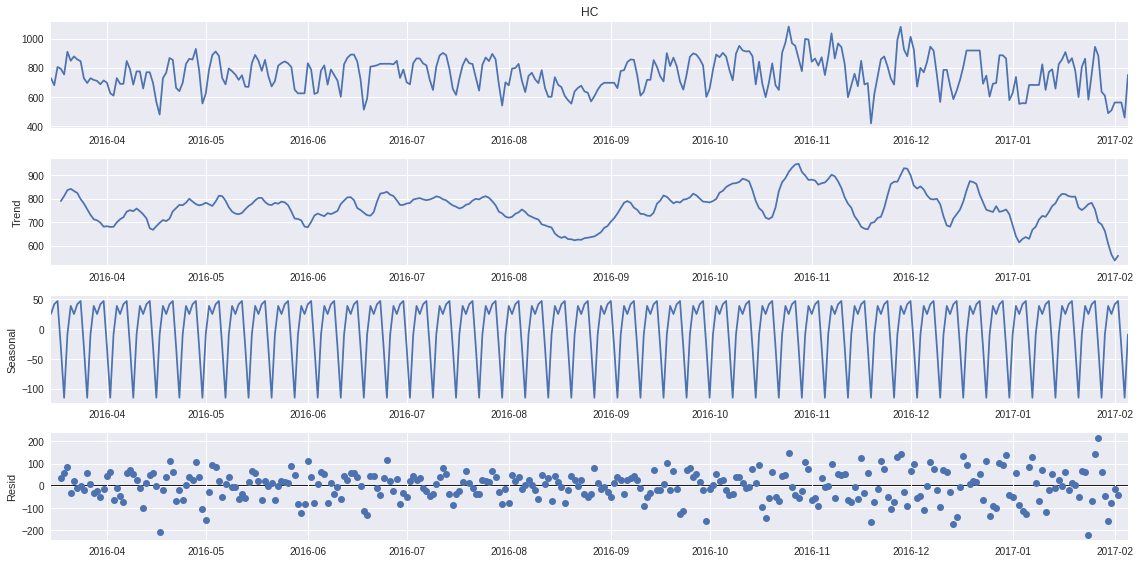

---

Seasonal Decomposition
Column: NO2
Seasonal 7


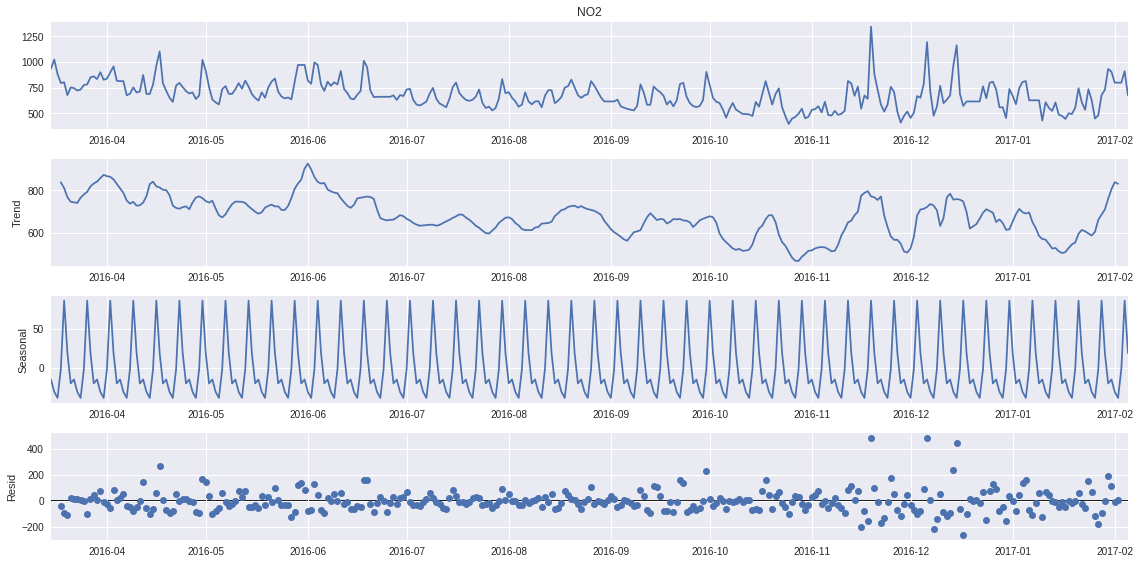

---

Seasonal Decomposition
Column: O3
Seasonal 7


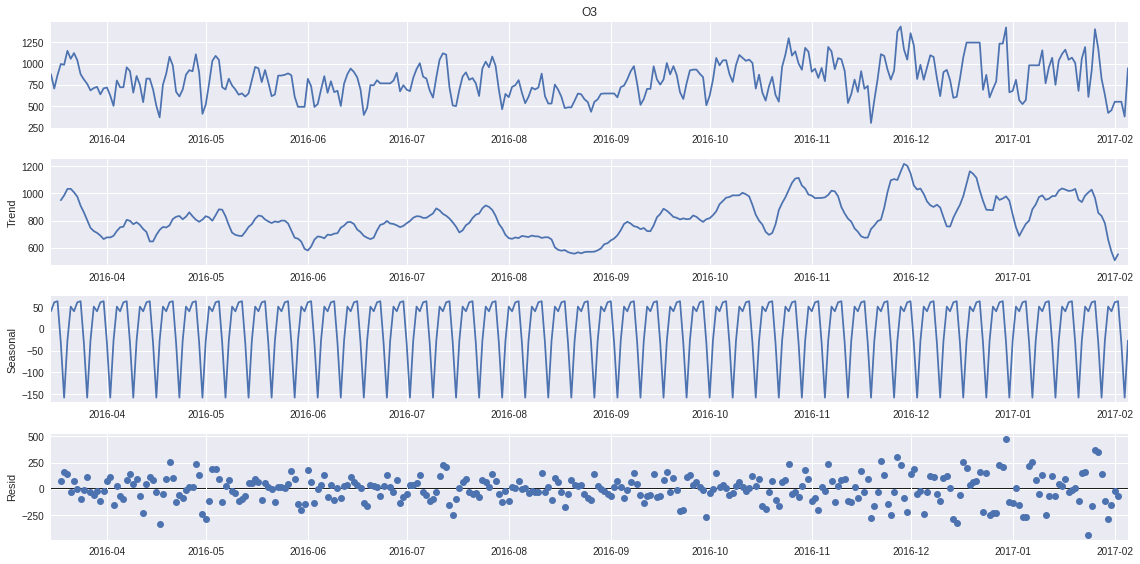

---

Seasonal Decomposition
Column: T
Seasonal 7


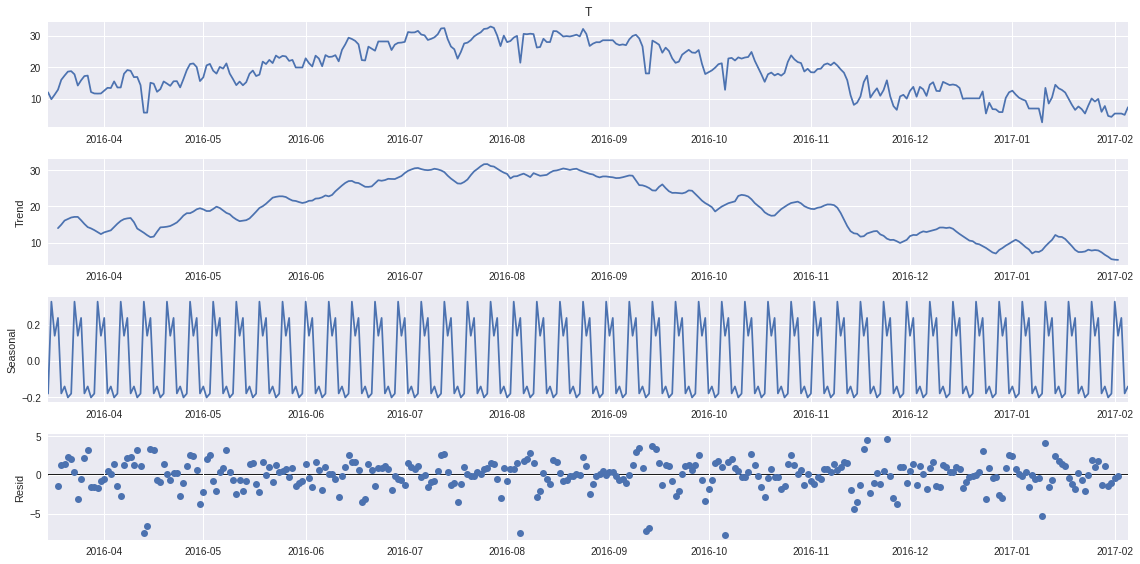

---

Seasonal Decomposition
Column: RH
Seasonal 7


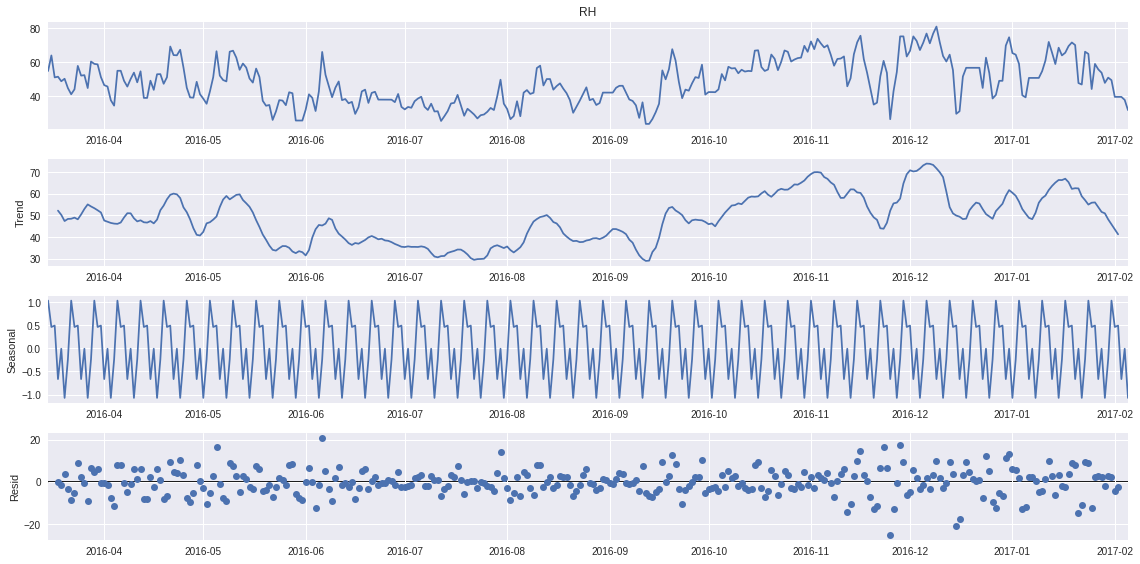

---

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal decomposition
display(Markdown('---'))
for i in df_pivot_impute.columns:
    print('Seasonal Decomposition\nColumn:', i)
    decomposition = seasonal_decompose(df_pivot_impute[i])
    print('Seasonal', len(decomposition.seasonal.drop_duplicates()))
    decomposition.plot()
    plt.show()
    display(Markdown('---'))